In [14]:
import unittest 
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
G = 0.1
dt = 0.01

In [15]:
class CosmicBody:
    """ 
    Класс космического тела

    Атрибуты:
    1) Масса - _mass_ float64  
    2) Начальная координата - _r_ массив из 3-х чисел 
    3) Скорость - _speed_ массив проекций скоростей
    4) Имя - _name_
    
    trajectory - тип траектории (вначале - неопределённый)
    history_r - массив координат, в который побывало тело (n x 3)

    """
    def __init__(self, mass: np.float64, r: np.ndarray, speed: np.ndarray, name: str):
        self.mass = mass
        self.speed = speed
        self.r = r
        self.trajectory = None
        self.history_r = np.array(self.r, dtype=np.float64)
        self.name = name


    def kinetik_energy(self)->np.float64:
      """ 
      Кинетическая энергия тела вычисляется по формуле mv^2/2
      На выходе получим float64
      """
      return self.mass * np.linalg.norm(self.speed)**2/2


      def __str__(self):
        """ 
      Функция возвращающая информацию о теле 
      Траектория выводится только, если определена 
        """
        if self.trajectory == None:
            return f'name:{self.name}, mass:{self.mass}, speed:{self.speed}, coordinates:{self.r}'
        else:
            return f'name:{self.name}, mass:{self.mass}, speed:{self.speed}, coordinates:{self.r}, trajectory:{self.trajectory}'


In [16]:
def energy_between_two_bodies(m0: np.float64, m1: np.float64, r0:np.ndarray, r1:np.ndarray) -> np.float64:
      """
      Энергия взаимодействия между двумя конкретными телами 
      m0, m1 - массы тел float64
      r0,r1 - координаты тел - np.ndarray
      Выводит float64
      """
      return -G * m0 * m1 / np.linalg.norm(r0 - r1)


def dv_(m : np.float64, r1 : np.ndarray, r2 : np.ndarray) -> np.float64:
      """ 
       Прирост скорости за ранее определённый промежуток времени

       m - масса тела, которое ускоряет np.float64
       r1 - координаты тела, которое ускоряется np.ndarray
       r2 - координаты тела, которое ускоряет np.ndarray

       Возвращаем np.float64

      """             
      return -dt * G * m * (r2 - r1) / np.linalg.norm(r2 - r1)**3


def full_energy(b: list) -> np.float64:
      """ 
  Считаем полную энергию системы 
  
  Принимаем на вход список всех тел, состоит из CosmicBody
  
  Сначала плюсуем кинетические энергии
  
  Потом плюсуем энергии взаимодействия тел убирая те что уже учли

  Возвращаем np.float64 по модулю

      """
      E = 0
      for i in range(len(b)):
          point = i+1
          E += b[i].kinetik_energy()
          while (point < len(b)):
              E += energy_between_two_bodies(b[i].mass, b[point].mass, b[i].r, b[point].r)
              point+=1
      return np.fabs(E)


def P_energy(i, b : list)-> np.float64:
      """ 
  Считаем потенциальную энергию взаимодействия тела i с телами из списка b

  Возвращаем np.float64
      """
      P = 0
      for j in b:
        P+= G * i.mass * j.mass / np.linalg.norm(i.r-j.r)
      return P


In [17]:
def dt_pass(b: list):
      """ 
  Функция которая принимаем список всех тел, находящихся в системе

  Привносит изменение в систему за время dt

  Меняем скорость, координаты
  Записываем координаты в историю
  Уничтожаем тела если столкнулись
  
      """
      for i in range(len(b)):
          for j in range(len(b)):
              if (j != i):
                  b[i].speed += dv_(b[j].mass, b[j].r, b[i].r)
          b[i].r += b[i].speed * dt
          b[i].history_r = np.vstack((b[i].history_r, b[i].r))

     # УНИЧТОЖИТЬ
      for j in range(len(b)):
          k = j+1
          while k < len(b):
              if (np.fabs(b[j].r - b[k].r) < 0.1).sum() == 3:
                  b.remove(b[j])
                  b.remove(b[k])
              k += 1
              

In [18]:
def main_loop(b : list, k : np.float64, stop : int, plot=True):
  """ 
  Основной цикл
  b - список всех тем системы list
  k - максимальное отклонение энергии в процентах при котором цикл остановится np.float64
  stop - максимальное количество итераций int
  plot - нужен ли график или нет bool

  f - полная энергия системы в начальный момент времени

  Выводит количество итераций
  """
  f = full_energy(b)
  cnt = 0
  while (np.fabs(full_energy(b) - f) < f * k) and (cnt < stop):
      cnt += 1
      dt_pass(b)
  if plot == True:
      fig = plt.figure(figsize=(10,10))
      ax = fig.add_subplot(projection='3d') #тридименсьон
      for x in b:
          ax.scatter(x.history_r[:, 0], x.history_r[:, 1], x.history_r[:, 2], label = x.name) #покоординатно строим график по накопленной истории 
      ax.legend() #легенда
      print('number of iterations:{}, initial total energy:{}, final total energy:{}'.format(cnt, round(f,6), round(full_energy(b),6)))
  return cnt

number of iterations:1000, initial total energy:7.0, final total energy:7.0


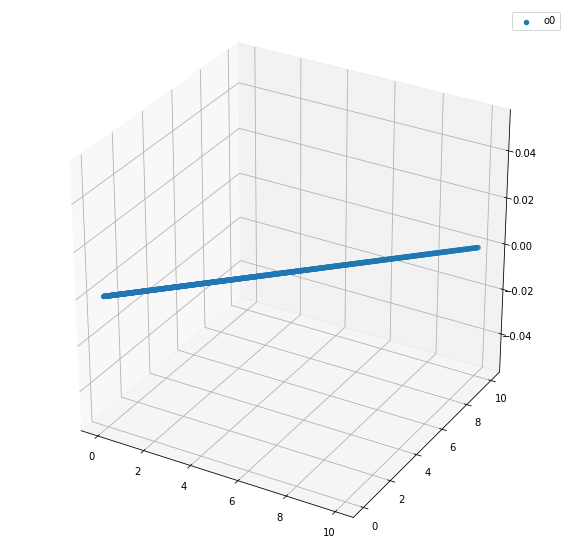

In [19]:
def one_object():
  """
  Тестируем создания одного объекта
  И отрисовку его графика
  """
  o0 = CosmicBody(7, np.array([0.,0.,0.]), np.array([1.,1.,0.]), 'o0')
  print(o0)
  main_loop([o0], 0.05, 1000)
one_object()

In [20]:
def trajectory_detection_function(b : list):
  """ 
  Устанавливаем тип траектории тел
  
  -20, 20 - парабола 
  меньше -20 - эллипс
  больше 20 - гипербола

  """
  for i in range(len(b)):
      E_each = b[i].kinetik_energy()
      for j in range(len(b)):
          if i != j:
              E_each += energy_between_two_bodies(b[i].mass, b[j].mass, b[i].r, b[j].r)

      if np.fabs(E_each) < 20:
          b[i].trajectory = "parabola"
      elif E_each > 20:
          b[i].trajectory = "hyperbola"
      else:
          b[i].trajectory = "ellips"
      print(b[i])
      